# Feature & Target Engineering


Data pre-processing and engineering techniques generally refer to the addition, deletion, or transformation of data.  The time spent on identifying data engineering needs can be significant and requires you to spend substantial time understanding your data...or as Leo Breiman said "live with your data before you plunge into modeling" {cite}`breiman2001statistical`. Although this book primarily focuses on applying machine learning algorithms, feature engineering can make or break an algorithm’s predictive ability and deserves your continued focus and education.

We will not cover all the potential ways of implementing feature engineering; however, we'll cover several fundamental pre-processing tasks that has the potential to significantly improve modeling performance. Moreover, different models have different sensitivities to the type of target and feature values in the model and we will try to highlight some of these concerns. For more in depth coverage of feature engineering, please refer to {cite}`kuhn2019feature` and {cite}`zheng2018feature`.

# Learning objectives

By the end of this module you will know:

- When and how to transform the response variable ("target engineering").
- How to identify and deal with missing values.
- When to filter unnecessary features.
- Common ways to transform numeric and categorical features.
- How to apply dimension reduction.
- How to properly combine multiple pre-processing steps into the modeling process.

# Prerequisites

In [27]:
# Helper packages
import missingno as msno
import modeldata
import numpy as np
import pandas as pd
from plotnine import *

# Modeling pre-processing with scikit-learn functionality
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Modeling pre-processing with non-scikit-learn packages
from category_encoders.ordinal import OrdinalEncoder
from feature_engine.encoding import RareLabelEncoder

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [3]:
# Ames housing data
ames = modeldata.load_dataset("ames")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

# Target engineering

Although not always a requirement, transforming the response variable can lead to predictive improvement, especially with parametric models which require that certain assumptions about the model be met. For instance, ordinary linear regression models assume that the prediction errors (and hence the response) are normally distributed. This is usually fine, except when the prediction target has heavy tails (i.e., _outliers_) or is skewed in one direction or the other. In these cases, the normality assumption likely does not hold. For example, as we saw in the data splitting section in the last module, the response variable for the Ames housing data (`Sale_Price`) is right (or positively) skewed ranging from \$12,789 to \$755,000. A simple linear model, say $\text{Sale_Price}=\beta_{0} + \beta_{1} \text{Year_Built} + \epsilon$, often assumes the error term $\epsilon$ (and hence `Sale_Price`) is normally distributed; fortunately, a simple log (or similar) transformation of the response can often help alleviate this concern as the below plot illustrates.

![](../images/engineering-skewed-residuals-1.png)

Furthermore, using a log (or other) transformation to minimize the response skewness can be used for shaping the business problem as well.  For example, in the [House Prices: Advanced Regression Techniques Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), which used the Ames housing data, the competition focused on using a log transformed Sale Price response  because _"...taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally."_ This would be an alternative to using the root mean squared logarithmic error (RMSLE) loss function as discussed in the last module.

There are three common approaches to help correct for positively skewed target variables:

1. Normalize with a log transformation. This will transform most right skewed distributions to be approximately normal. 

2. If your response has negative values or zeros then a log transformation will produce `NaN`s and `-Inf`s, respectively (you cannot take the logarithm of a negative number).  If the nonpositive response values are small (say between -0.99 and 0) then you can apply a small offset such as in `numpy.log1p()` which adds 1 to the value prior to applying a log transformation. If your data consists of values $\le -1$, use the Yeo-Johnson transformation instead.

3. (__Preferred__) Use a _Box Cox transformation_. A Box Cox transformation is more flexible than (but also includes as a special case) the log transformation and will find an appropriate transformation from a family of power transforms that will transform the variable as close as possible to a normal distribution {cite}`box1964analysis, carroll1981prediction`. At the core of the Box Cox transformation is an exponent, lambda ($\lambda$), which varies from -5 to 5. All values of $\lambda$ are considered and the optimal value for the given data is estimated from the training data; The "optimal value" is the one which results in the best transformation to an approximate normal distribution. The transformation of the response $Y$ has the form:

$$
 \begin{equation} 
 y(\lambda) =
\begin{cases}
   \frac{Y^\lambda-1}{\lambda}, & \text{if}\ \lambda \neq 0 \\
   \log\left(Y\right), & \text{if}\ \lambda = 0.
\end{cases}
\end{equation}
$$

```{tip}
If your response has negative values, the Yeo-Johnson transformation is very similar to the Box-Cox but does not require the input variables to be strictly positive.
```

Below illustrates that the log transformation and Box Cox transformation both do about equally well in transforming `Sale_Price` to look more normally distributed.

![](../images/engineering-distribution-comparison-1.png)

In Python we use `TransformedTargetRegressor()` to build a plan for target engineering. This will not return the actual log/box-cox transformed values but, rather, a blueprint to be applied later. In this example we are simply building an object that will apply a Box-Cox transformation to the target variable when we fit our model.

```{tip}
There is a `sklearn.preprocessing.power_transform` function that can be applied to immediately transform an array. However, later in this module we'll discuss the idea of data leakage and how important it is to create isolated pre-processing steps.
```

In [4]:
tt = TransformedTargetRegressor(transformer=PowerTransformer(method='box-cox'))
tt

TransformedTargetRegressor(transformer=PowerTransformer(method='box-cox'))

# Dealing with missingness

Data quality is an important issue for any project involving analyzing data. Data quality issues deserve an entire book in their own right, and a good reference is [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide). One of the most common data quality concerns you will run into is missing values.

Data can be missing for many different reasons; however, these reasons are usually lumped into two categories: _informative missingness_ {cite}`apm` and _missingness at random_ {cite}`little2014statistical`. Informative missingness implies a structural cause for the missing value that can provide insight in its own right; whether this be deficiencies in how the data was collected or abnormalities in the observational environment.  Missingness at random implies that missing values occur independent of the data collection process[^missing_at_random].

[^missing_at_random]: {cite}`little2014statistical` discuss two different kinds of missingness at random; however, we combine them for simplicity as their nuanced differences are distinguished between the two in practice. 

The category that drives missing values will determine how you handle them.  For example, we may give values that are driven by informative missingness their own category (e.g., `"None"`) as their unique value may affect predictive performance.  Whereas values that are missing at random may deserve deletion[^missing_at_random2] or imputation. 

[^missing_at_random2]: If your data set is large, deleting missing observations that have missing values at random rarely impacts predictive performance. However, as your data sets get smaller, preserving observations is critical and alternative solutions should be explored.

Furthermore, different machine learning models handle missingness differently.  Most algorithms cannot handle missingness (e.g., generalized linear models and their cousins, neural networks, and support vector machines) and, therefore, require them to be dealt with beforehand.  A few models (mainly tree-based), have built-in procedures to deal with missing values.  However, since the modeling process involves comparing and contrasting multiple models to identify the optimal one, you will want to handle missing values prior to applying any models so that your algorithms are based on the same data quality assumptions.

## Visualizing missing values

It is important to understand the distribution of missing values (i.e., `NA`) in any data set. So far, we have been using a pre-processed version of the Ames housing data set. However, if we use the [raw Ames housing data](https://rdrr.io/cran/AmesHousing/man/ames_raw.html), there are actually `r scales::comma(sum(is.na(AmesHousing::ames_raw)))` missing values---there is at least one missing value in each row of the original data! Good visualizations can help us understand patterns in the missing data.

In [5]:
ames_raw = pd.read_csv("../data/ames_raw.csv")

# count total missing values
ames_raw.isnull().sum().sum()

13997

```{tip}
Check out the [missingno](https://github.com/ResidentMario/missingno) package to see all the great ways to to visualize missing data!
```

<AxesSubplot:>

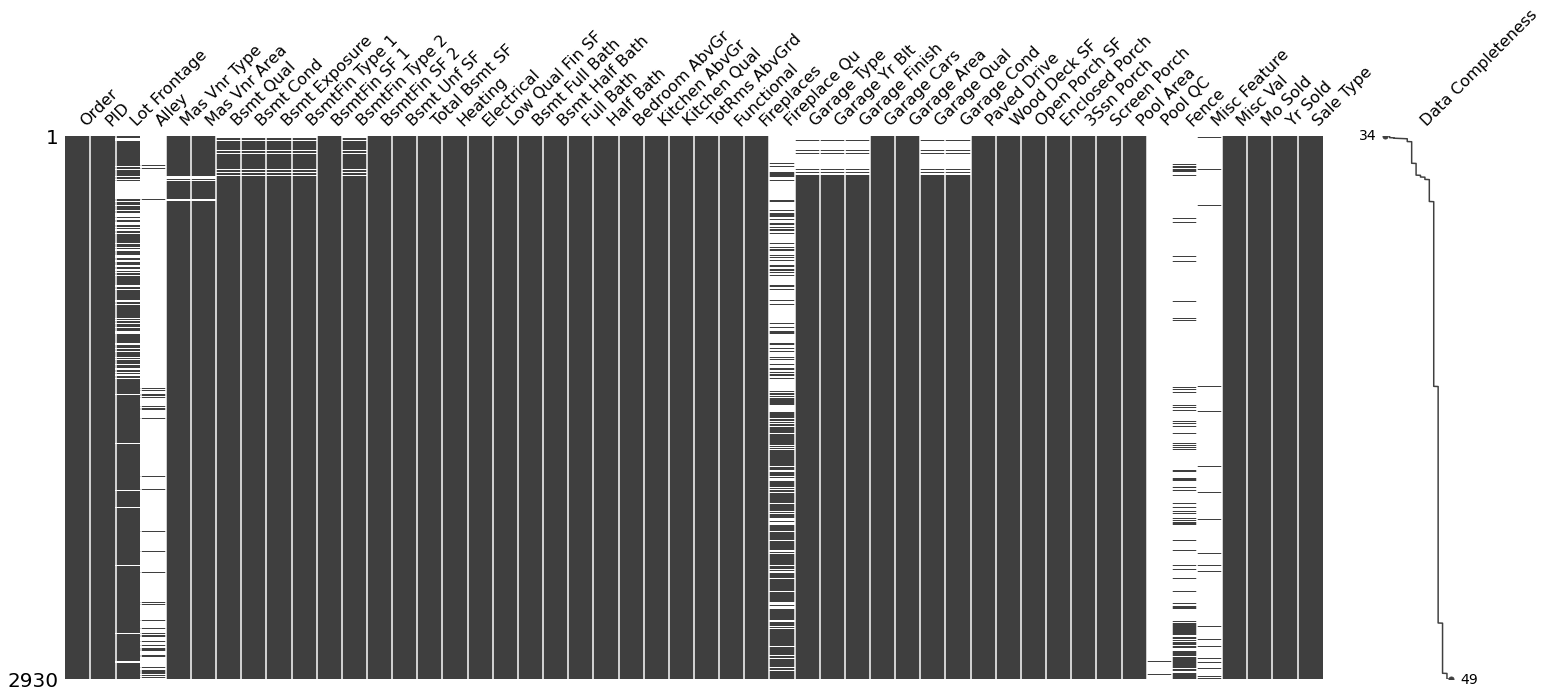

In [6]:
# can you identify patterns of missing data
# missingness is represented with white
msno.matrix(ames_raw, labels=True, filter="bottom", sort="ascending", n=50)

<AxesSubplot:>

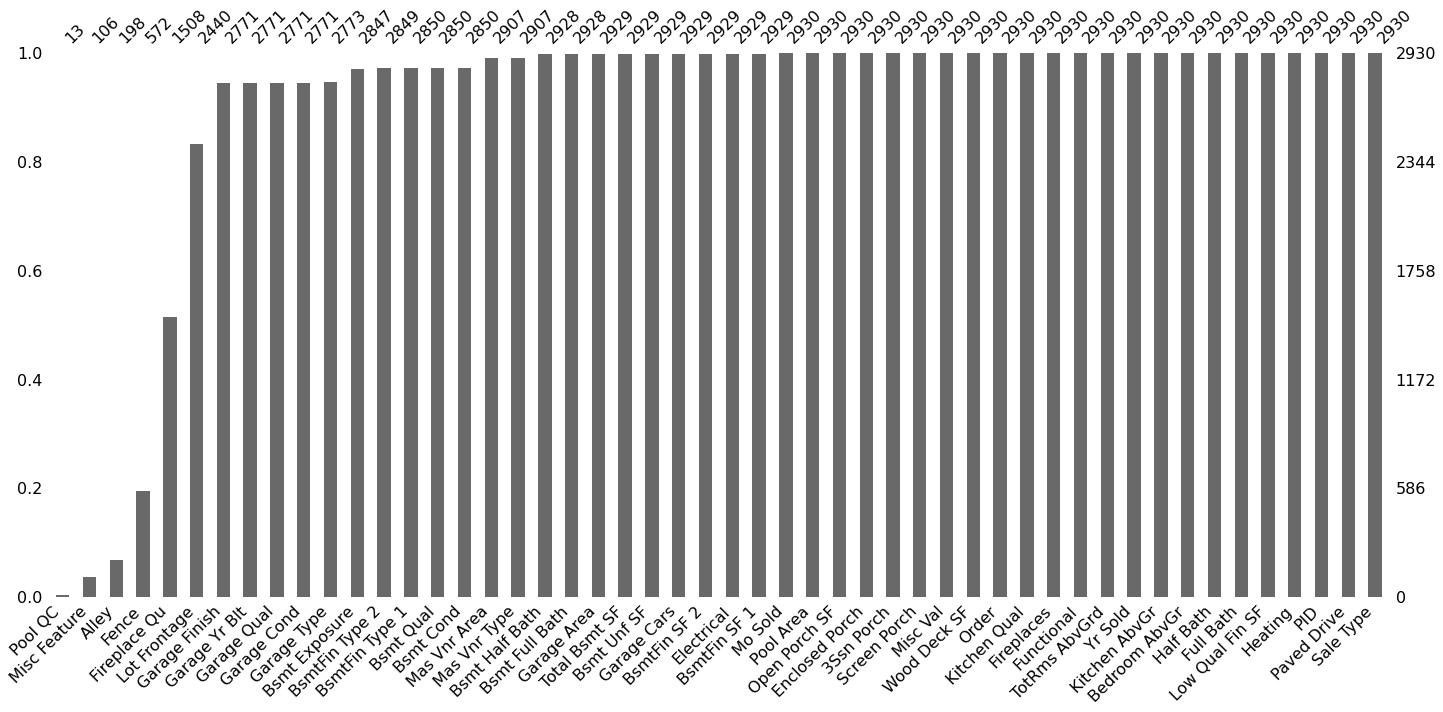

In [7]:
# which features have most missing?
# this chart shows the number of observations so small bars (i.e. Pool QC)
# represent very few observed values (lots of missingness)
msno.bar(ames_raw, labels=True, filter="bottom", sort="ascending", n=50)

## Imputation

_Imputation_ is the process of replacing a missing value with a substituted, "best guess" value. Imputation should be one of the first feature engineering steps you take as it will affect any downstream pre-processing[^imputation1].

[^imputation1]: For example, standardizing numeric features will include the imputed numeric values in the calculation and one-hot encoding will include the imputed categorical value. 

### Estimated statistic

An elementary approach to imputing missing values for a feature is to compute descriptive statistics such as the mean, median, or mode (for categorical) and use that value to replace `NA`s. Although computationally efficient, this approach does not consider any other attributes for a given observation when imputing (e.g., a female patient that is 63 inches tall may have her weight imputed as 175 lbs since that is the average weight across all observations which contains 65% males that have an average a height of 70 inches).  

An alternative is to use grouped statistics to capture expected values for observations that fall into similar groups. However, this becomes infeasible for larger data sets.  Modeling imputation can automate this process for you and the two most common methods include K-nearest neighbor and tree-based imputation, which are discussed next.

However, it is important to remember that imputation should be performed __within the resampling process__ and as your data set gets larger, repeated model-based imputation can compound the computational demands.  Thus, you must weigh the pros and cons of the two approaches.

The following code snippet shows how to impute different features with the median value of a given feature. 

In Python, the [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) can be used to apply an imputation to all features. However, if you only want to apply imputation to a subset of features then you would use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) in addition to the `SimpleImputer` strategy.

```{warning}
These imputers do not yet perform imputation. At the end of this module we will show you how all these pieces of the feature engineering come together in our ML modeling pipeline.
```

In [8]:
# median imputation to all features
a = SimpleImputer(strategy='median')

# median imputation to just numeric predictors
b = ColumnTransformer([("num_imp", a, selector(dtype_include="number"))])

# median imputation to 1 or more features
c = ColumnTransformer([("num_imp", a, selector("Gr_Liv_Area"))])

### K-nearest neighbor

_K_-nearest neighbor (KNN) imputes values by identifying observations with missing values, then identifying other observations that are most similar based on the other available features, and using the values from these nearest neighbor observations to impute missing values.

We discuss KNN for predictive modeling in a later module; the imputation application works in a similar manner.  In KNN imputation, the missing value for a given observation is treated as the targeted response and is predicted based on the average (for quantitative values) or the mode (for qualitative values) of the _k_ nearest neighbors.

As discussed in the KNN modeling module, if all features are quantitative then standard Euclidean distance is commonly used as the distance metric to identify the _k_ neighbors and when there is a mixture of quantitative and qualitative features then Gower's distance {cite}`gower1971general` can be used. KNN imputation is best used on small to moderate sized data sets as it becomes computationally burdensome with larger data sets {cite}`kuhn2019feature`.

```{tip}
As we saw in the last module, **k** is a tunable hyperparameter. Suggested values for imputation are 5--10 {cite}`kuhn2019feature`.
```

In [9]:
knn_imp = KNNImputer(n_neighbors=6)

```{tip}
Read more about Scikit-Learn's imputation options [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute).
```

The plot below illustrates the differences between mean and KNN-based imputation on the raw Ames housing data. The red points represent actual values which were removed and made missing and the blue points represent the imputed values. Estimated statistic imputation methods (i.e. mean, median) merely predict the same value for each observation and can reduce the signal between a feature and the response; whereas KNN imputation procedures tend to maintain the feature distribution and relationship.

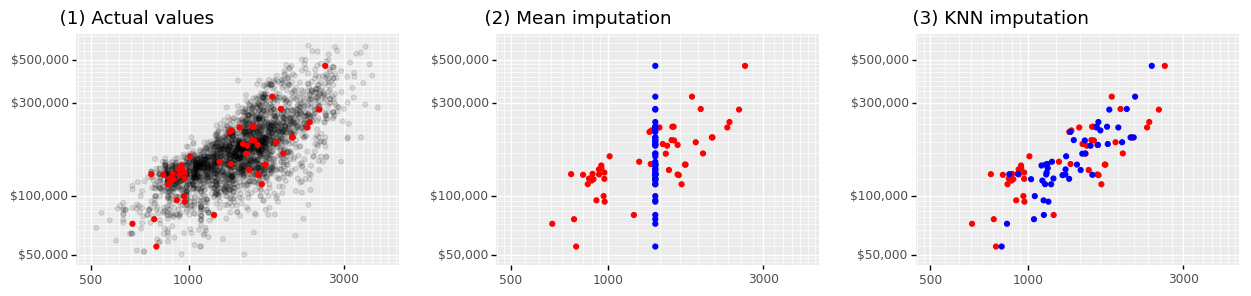

In [148]:
from matplotlib import gridspec
from mizani import formatters
import random
import warnings

warnings.filterwarnings('ignore', module='plotnine')

random.seed(123)
sample_index = random.sample(list(ames.index), 50)

# identify actuals
actuals = ames.iloc[sample_index].copy()
p1 = (
    ggplot()
    + geom_point(ames, aes(x="Gr_Liv_Area", y="Sale_Price"), alpha=0.1)
    + geom_point(actuals, aes(x="Gr_Liv_Area", y="Sale_Price"), color='red')
    + scale_x_log10(limits=(500, 4000))
    + scale_y_log10(
        limits=(50000, 600000),
        labels=formatters.currency_format(digits=0, big_mark=',')
        )
    + ggtitle("Actual values")
)

# mean imputed
mean_impute = actuals.copy()
mean_impute['Gr_Liv_Area'] = actuals['Gr_Liv_Area'].mean()
p2 = (
    ggplot()
    + geom_point(actuals, aes(x="Gr_Liv_Area", y="Sale_Price"), color='red')
    + geom_point(mean_impute, aes(x="Gr_Liv_Area", y="Sale_Price"), color='blue')
    + scale_x_log10(limits=(500, 4000))
    + scale_y_log10(
        limits=(50000, 600000),
        labels=formatters.currency_format(digits=0, big_mark=',')
        )
    + ggtitle("Mean imputation")
)

# knn imputed
knn_imp = KNNImputer(n_neighbors=6)
ames_numeric = ames.select_dtypes(include=[np.number]).copy()
ames_numeric.loc[sample_index, 'Gr_Liv_Area'] = np.nan
knn_impute = knn_imp.fit_transform(ames_numeric)
knn_impute = pd.DataFrame(knn_impute, columns=ames_numeric.columns).iloc[sample_index]
p3 = (
    ggplot()
    + geom_point(actuals, aes(x="Gr_Liv_Area", y="Sale_Price"), color='red')
    + geom_point(knn_impute, aes(x="Gr_Liv_Area", y="Sale_Price"), color='blue')
    + scale_x_log10(limits=(500, 4000))
    + scale_y_log10(
        limits=(50000, 600000),
        labels=formatters.currency_format(digits=0, big_mark=',')
        )
    + ggtitle("KNN imputation")
)

# Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).

fig = (
    ggplot()
    + geom_blank(data=ames)
    + theme_void()
    + theme(figure_size=(15, 3))
    # such a hack it's embarrassing!
    + ggtitle((
        "    " +
        "(1) Actual values                                              " +
        "(2) Mean imputation                                         " +
        "(3) KNN imputation                          "
        ))
    ).draw()

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(1, 3, wspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])
_ = p3._draw_using_figure(fig, [ax3])


# Feature filtering

# Numeric feature engineering

# Categorical feature engineering

# Dimension reduction

# Proper implementation

# References


```{bibliography}
```